In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = datasets.MNIST(root='/scratch/yardima/data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='/scratch/yardima/data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=2)

tensor([9, 2, 4, 3, 0, 0, 9, 3, 4, 0, 3, 0, 8, 7, 2, 7, 7, 0, 8, 0, 2, 2, 7, 3,
        1, 5, 2, 6, 3, 0, 6, 0])


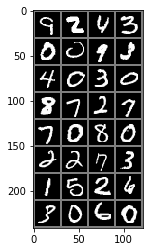

In [6]:
dataiter = iter(trainloader)
i, l = dataiter.next()

g = torchvision.utils.make_grid(i, nrow=4)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

print(l)

## Test metric learning/CNN

In [7]:
class CNN(nn.Module):
    
    def __init__(self, *, embed_dim):
        super(CNN, self).__init__()
        
        self.c1 = nn.Conv2d(1, 16, kernel_size=5)
        self.c2 = nn.Conv2d(16, 32, kernel_size=5)
        self.c3 = nn.Conv2d(32, 16, kernel_size=5)
        self.c4 = nn.Conv2d(16, 16, kernel_size=5)
        self.c5 = nn.Conv2d(16, embed_dim, kernel_size=12)
        
        self.EMBED_DIM = embed_dim
    
    def forward(self, x):
        
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = self.c5(x)
        
        x = x.view(-1, self.EMBED_DIM)
        
        return x

In [8]:
cnn = CNN(embed_dim=10)

## print number of parameters in network:
pcount = 0
for p in cnn.parameters():
    pcount += p.numel()
    
print("Total trainable parameter count: {}".format(pcount))

Total trainable parameter count: 55530


## Prepare dataset for triplet loss

In [9]:
classindices = []
trainy = trainset.train_labels.data.numpy()
for i in range(10):
    classindices.append(np.nonzero(trainy == i)[0])

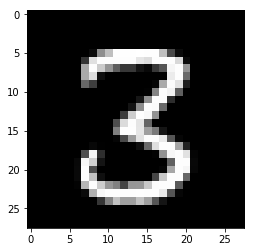

In [10]:
sample = trainset[classindices[3][447]][0]
g = torchvision.utils.make_grid(sample, nrow=1)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [11]:
def gen_triplet(dataset, classindices, n_samples):
    X = []
    y = []
    for i in range(n_samples):
        c = np.random.choice(10, size=2, replace=False)
        
        p_samples = np.random.choice(classindices[c[0]], size=2, replace=False)
        n_sample = np.random.choice(classindices[c[1]], size=1)
        
        X.append(dataset[p_samples[0]][0])
        X.append(dataset[p_samples[1]][0])
        X.append(dataset[n_sample[0]][0])
        
        y.append(dataset[p_samples[0]][1])
        y.append(dataset[p_samples[1]][1])
        y.append(dataset[n_sample[0]][1])
        
    return (torch.stack(X), 
            torch.stack(y))

## Train model with different hyper-parameters

In [12]:
def triplet_loss(loss_fun, output, n_samples, target, reg):
    ix = np.arange(n_samples, dtype=np.int32) * 3
    
    distp = (output[ix] - output[ix + 1]).pow(2).sum(dim=1)
    distn = (output[ix] - output[ix + 2]).pow(2).sum(dim=1)
    
    norm_loss = output.pow(2).sum() / n_samples
    loss_dist = loss_fun(distn, distp, target) / n_samples
    
    return reg * norm_loss + loss_dist

In [13]:
cnn = CNN(embed_dim=10)
optimizer = optim.SGD(cnn.parameters(), lr = 1e-3, momentum=0.9)
lr_update = lambda epoch: 0.9 ** epoch
cnn = cnn.to(device)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_update)

In [ ]:
%%time
reg = 3e-3
margin = 1
loss_fun = nn.MarginRankingLoss(margin=margin)
n_samples = 3

epoch_size = 10000

for e in range(100):
    running_loss = 0.
    scheduler.step()
    
    for i in range(1, 10000):
        x, label = gen_triplet(trainset, classindices, n_samples)
        x = x.to(device)
        target = torch.FloatTensor(n_samples).fill_(1).to(device)
        
        optimizer.zero_grad()
        out = cnn.forward(x)
        loss = triplet_loss(loss_fun, out, n_samples, target, reg)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 1250 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i, running_loss / 1250))
            running_loss = 0.

[1,  1250] loss: 0.237
[1,  2500] loss: 0.087
[1,  3750] loss: 0.059
[1,  5000] loss: 0.046
[1,  6250] loss: 0.039
[1,  7500] loss: 0.035
[1,  8750] loss: 0.035
[2,  1250] loss: 0.030
[2,  2500] loss: 0.028
[2,  3750] loss: 0.026
[2,  5000] loss: 0.026
[2,  6250] loss: 0.027
[2,  7500] loss: 0.026
[2,  8750] loss: 0.024
[3,  1250] loss: 0.022
[3,  2500] loss: 0.024


In [ ]:
torch.save(cnn, '/home/yardima/Python/models/model3')

## Evaluate model

### Compute embeddings for all samples

In [14]:
# load model
embed_model = torch.load('/home/yardima/Python/models/model3')
embed_model.to(device)

CNN(
  (c1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (c2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (c3): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (c4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (c5): Conv2d(16, 10, kernel_size=(12, 12), stride=(1, 1))
)

In [15]:
train_embed = []
train_label = []
with torch.autograd.no_grad():
    for x, label in trainset:
        x = x.to(device).view(1, 1, 28, 28)
        y = embed_model.forward(x).cpu().data.numpy()
        train_embed.append(y)
        train_label.append(label.item())
        
train_embed = np.array(train_embed)
train_label = np.array(train_label, dtype=np.int32)

In [16]:
train_embed = train_embed.reshape((-1, embed_model.EMBED_DIM))

In [17]:
test_embed = []
test_label = []
with torch.autograd.no_grad():
    for x, label in testset:
        x = x.to(device).view(1, 1, 28, 28)
        y = embed_model.forward(x).cpu().data.numpy()
        test_embed.append(y)
        test_label.append(label.item())
        
test_embed = np.array(test_embed)
test_label = np.array(test_label, dtype=np.int32)

In [18]:
test_embed = test_embed.reshape((-1, embed_model.EMBED_DIM))

### Test k-NN classifier on Embeddings

In [19]:
from sklearn.neighbors import KNeighborsClassifier

nn1_classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=8)
nn3_classifier = KNeighborsClassifier(n_neighbors=3, n_jobs=8)
nn5_classifier = KNeighborsClassifier(n_neighbors=5, n_jobs=8)

In [20]:
nn1_classifier.fit(train_embed, train_label)
nn3_classifier.fit(train_embed, train_label)
nn5_classifier.fit(train_embed, train_label)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
%%time
pred1 = nn1_classifier.predict(test_embed)

In [21]:
%%time
pred3 = nn3_classifier.predict(test_embed)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [32]:
%%time
pred5 = nn5_classifier.predict(test_embed)

CPU times: user 2.66 s, sys: 8 ms, total: 2.67 s
Wall time: 2.85 s


In [33]:
print("k-NN classification on MNIST embeddings (k=1)")
print(np.mean(pred1 == test_label))

k-NN classification on MNIST embeddings (k=1)
0.5628


In [34]:
print("k-NN classification on MNIST embeddings (k=3)")
print(np.mean(pred3 == test_label))

k-NN classification on MNIST embeddings (k=1)
0.5994


In [35]:
print("k-NN classification on MNIST embeddings (k=5)")
print(np.mean(pred5 == test_label))

k-NN classification on MNIST embeddings (k=1)
0.6294


In [37]:
%%time
nn7_classifier = KNeighborsClassifier(n_neighbors=7, n_jobs=8)
nn7_classifier.fit(train_embed, train_label)
pred7 = nn7_classifier.predict(test_embed)
print("k-NN classification on MNIST embeddings (k=7)")
print(np.mean(pred7 == test_label))

k-NN classification on MNIST embeddings (k=7)
0.642
CPU times: user 2.97 s, sys: 4 ms, total: 2.97 s
Wall time: 3.25 s


In [40]:
%%time
nn15_classifier = KNeighborsClassifier(n_neighbors=15, n_jobs=8)
nn15_classifier.fit(train_embed, train_label)
pred15 = nn15_classifier.predict(test_embed)
print("k-NN classification on MNIST embeddings (k=15)")
print(np.mean(pred15 == test_label))

k-NN classification on MNIST embeddings (k=15)
0.6552
CPU times: user 3.55 s, sys: 12 ms, total: 3.56 s
Wall time: 3.95 s


## Test t-SNE plots